# Comparing Machine Learning Methods for Water Height Predictions

## **Group 3:** Ankita Mishra, Daniel Li, Emma Stefanovich, Matthew Mackey

---

## **Models 3 and 4:** XGBoost and Random Forest

### Emma Stefanovich

In [2]:
# Libraries

# Overview, EDA, and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score # Huber loss isn't included in sklearn.metrics
from IPython.display import SVG, display

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

# Evaluation

In [3]:
# You can un-comment this code to install any packages you need.
#import sys
#!{sys.executable} -m pip install xgboost

# Use this for setting up GraphViz (if you don't already have it installed), which is needed to make one visualization later on.
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-12.2.1/bin/'

**Goal:**

Build and compare two supervised regression models (XGBoost and Random Forest) to forecast future gauge height (ft) at stream gauges using hydrological features in USGS data set.

**Data description:**

The United States Geological Survey (USGS) water data set is a collection of hydrological data that includes measurements of water height, flow, and other related parameters across various locations in the U.S. This data set is crucial for managing water resources, as it provides detailed insights into the behavior of water bodies over time.

This project uses a subset of data for the state of Oklahoma, selecting for stream flow and gauge height, every 15/30 minutes (depending on gauge) for 14 days. Data subset includes 23,000 samples for 41 gauge sites.

Link to data set source: [USGS Current Water Data for the Nation](https://waterdata.usgs.gov/nwis/rt)

Features:

- `site`: gauge ID number

- `time`: datetime of gauge recording (m/d/yyyy hh:mm)

- `flow`: current stream flow water volume per second (ft$^3$/s)

- `height`: current height of water at gauge (ft)

- `height_diff`: difference in height between gauge height and upstream gauge height ($\Delta$ ft)

- `upstr_flow`: current stream flow water volume per second (ft$^3$/s) at upstream gauge

- `upst_tm30`: lagged upstream stream flow water volume (ft$^3$/s), 30 minutes

- `upst_tm60`: lagged upstream stream flow water volume (ft$^3$/s), 60 minutes

- `upst_tm90`: lagged upstream stream flow water volume (ft$^3$/s), 90 minutes

- `upst_flow_dif`: difference in stream flow water volume between gauge and upstream gauge ($\Delta$ ft$^3$/s)

- `move_avg`: rolling mean for the most recent 3 times for the gauge height

- `tplus30m`: gauge height (ft) 30 minutes after current record

- `tplus1h`: gauge height (ft) 1 hour after current record

- `tplus2h`: gauge height (ft) 2 hours after current record

- `tplus4h`: gauge height (ft) 4 hours after current record

- `tplus8h`: gauge height (ft) 8 hours after current record

Target: Gauge height at future time horizons (+30 min, +1 h, +2 h, etc.)

**Overview:**

1. Data Overview

    - Load the data set (ok_water_data.csv).
      
    - Check shape, time span, number of sites, missing values, summary statistics.

2. Exploratory Data Analysis (EDA)

    - Verify/fix data types.

    - Examine time-series plots of height and flow for a few example sites.

    - Examine distribution of each feature.

    - Examine correlations between features and between each feature and the target (height at various horizons).

4. Data Preprocessing

    - Fix any issues found during Overview/EDA.
    
    - Handle timestamp variable.

    - Train/test split (possible approaches: simple 80/20 random split, 80/20 temporal split/time-based holdout).

5. Modeling

    - Model 1: XGBoost (XGB):

        - Set up xgboost.XGBRegressor within a sklearn.Pipeline pipeline.

        - Define hyperparameter grid.

        - Use RandomizedSearchCV on the training fold.
     
        - Compute RMSE, MAE, MAPE, Huber loss, and R$^2$ on the held-out test set across each forecasting horizon (+30 min, +1 h, +2 h, etc.).
     
        - Extract feature importances.

    - Model 2: Random Forest (RF):

        - Similar process as XGB but with sklearn.ensemble.RandomForestRegressor.

        - Compute RMSE, MAE, MAPE, Huber loss, and R$^2$ on the held-out test set across each forecasting horizon (+30 min, +1 h, +2 h, etc.).
     
        - Extract and plot feature importances (permutation importance).

6. Evaluation

    - Plot error vs. forecast horizon for each model.
      
    - Visualize models.
  
    - Discuss model differences.
  
    - Discuss limitations.
  
    - Fine-tune best model for later use.

## **1.** Data Overview

In [6]:
df = pd.read_csv('ok_water_data.csv', parse_dates=['time'])

# Data Overview
print("Shape of data:", df.shape)
print("\nData sample:\n")
print(df.head(5))
print("\nData types and non-null counts:\n")
print(df.info())
print("\nBasic statistics:\n")
print(df.describe())
print("\nMissing values per column:\n")
print(df.isnull().sum())

# Time span and site count
min_time, max_time = df['time'].min(), df['time'].max()
print(f"\nOverall time span: {min_time} to {max_time}")
print("\nNumber of unique sites:", df['site'].nunique())

Shape of data: (23463, 16)

Data sample:

      site                time   flow  height  height_diff  upstr_flow  \
0  7152000 2025-04-02 22:30:00  121.0    2.40     0.000000        66.3   
1  7152000 2025-04-02 23:00:00  118.0    2.39    -0.006667        66.3   
2  7152000 2025-04-02 23:30:00  118.0    2.39    -0.003333        66.3   
3  7152000 2025-04-03 00:00:00  116.0    2.38    -0.006667        68.3   
4  7152000 2025-04-03 00:30:00  116.0    2.38    -0.003333        66.3   

   upst_tm30  upst_tm60  upst_tm90  upst_flow_dif  move_avg  tplus30m  \
0       66.3       66.3       66.3            0.0  2.400000      2.39   
1       66.3       66.3       66.3            0.0  2.396667      2.39   
2       66.3       66.3       66.3            0.0  2.393333      2.38   
3       66.3       66.3       66.3            2.0  2.386667      2.38   
4       68.3       66.3       66.3           -2.0  2.383333      2.38   

   tplus1h  tplus2h  tplus4h  tplus8h  
0     2.39     2.38     2.38     2

**Overview results:**

Data set:

- No missing values. Every column (including all targets and predictors) has a non‐null count of 23,463. That means we don't need to impute or drop rows.

- The timestamps (`time`) run from 2025-04-01 02:30 through 2025-04-14 17:00, which is about two weeks of data, as expected.

- There are 41 distinct sites.

Notable feature distributions:

- stream flow (`flow`) is heavily right‐skewed. Min is -3980, which seems odd, since volume of water flow should be non-negative (considering it's measured in ft$^3$/s, and you can't logically have a negative volume of water per second). We will visually examine the distribution of stream flow to get a better idea of its shape, and we can count how many values in the data are negative to see if we should simply drop them. Mean is about 1442, Max is 59,400, and Std is about 4652.

- Gauge height (`height`) also shows some large values (Max is about 87.54 with a mean of about 8.63 and Std of about 13.65).

- All the upstream features (`upstr_flow`, `upst_tm30`, etc.) mirror that same skew: large ranges, large Std relative to the median.

- Targets roughly follow height distribution. If we look at the summaries for `tplus30m` through `tplus8h`, the means (about 8.63) and Stds (about 13.65) almost exactly match the current‐time `height` stats.

## **2.** Exploratory Data Analysis (EDA)

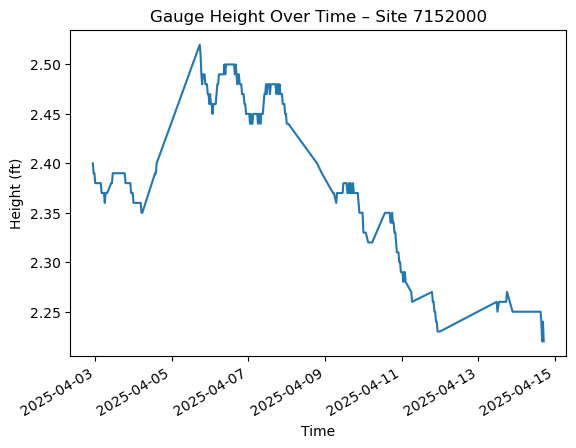

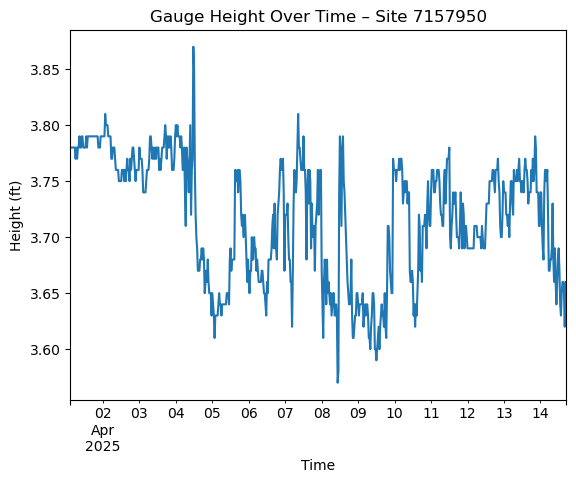

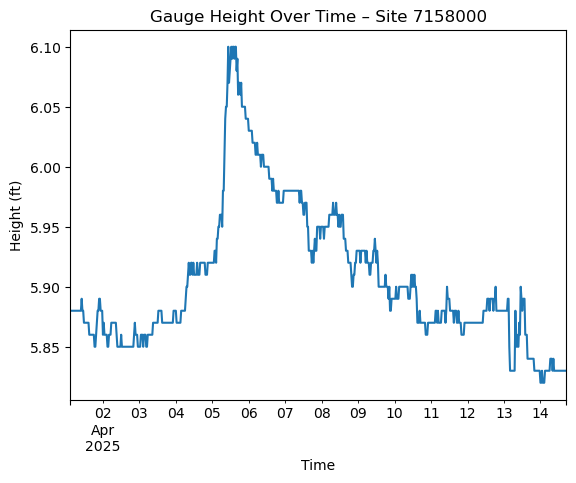

In [9]:
# Time-series graphs for three example sites
example_sites = df['site'].unique()[:3]
for site in example_sites:
    subset = df[df['site'] == site].set_index('time')
    plt.figure()
    subset['height'].plot(title = f"Gauge Height Over Time – Site {site}")
    plt.xlabel('Time')
    plt.ylabel('Height (ft)')
    plt.show()

The gauge height measurements look quite different between these three example sites. The first (7152000) and third (7158000) sites show a spike in gauge height around April 6 followed by a drop-off, while the second site (7157950) is far more erratic.

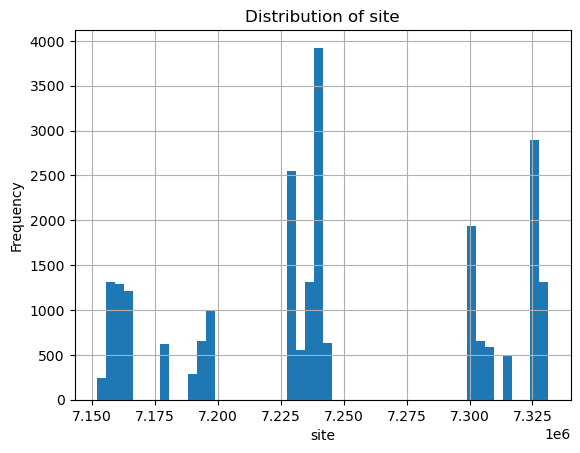

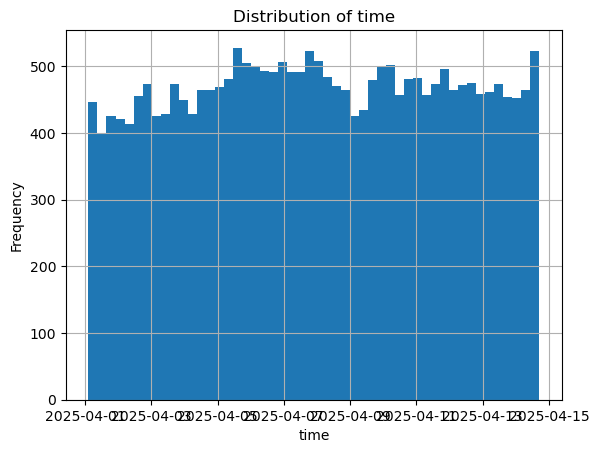

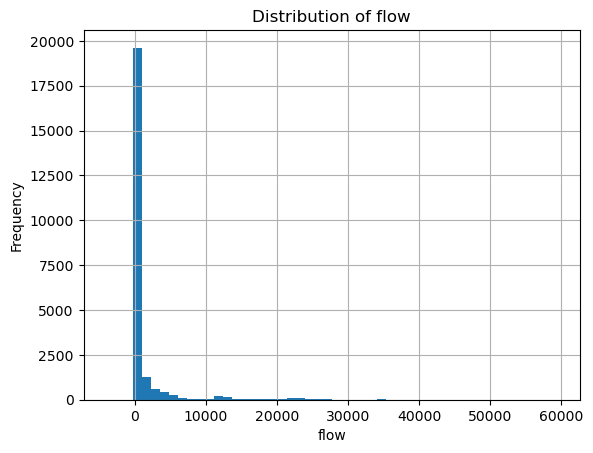

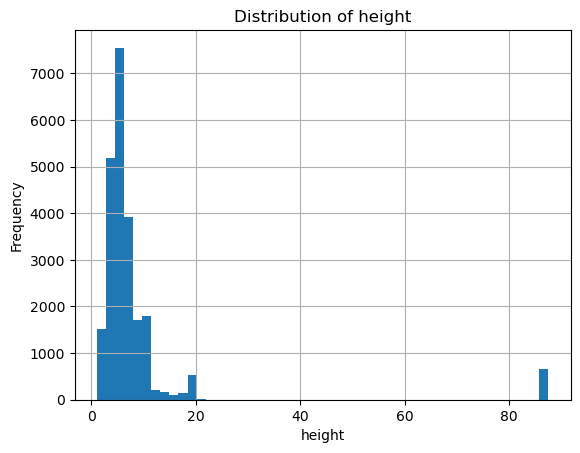

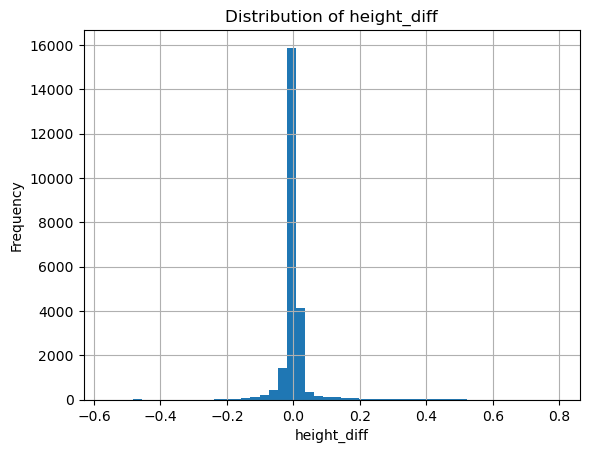

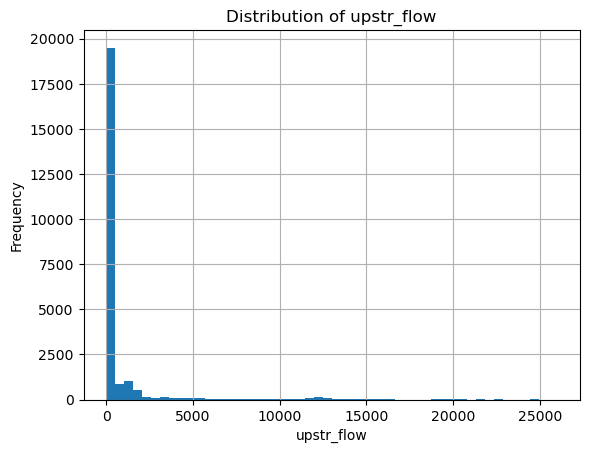

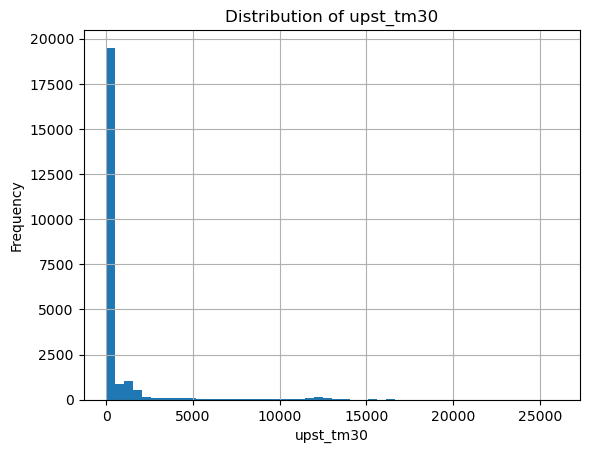

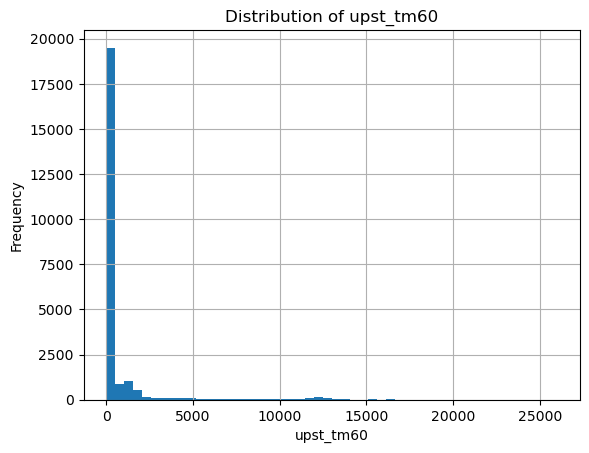

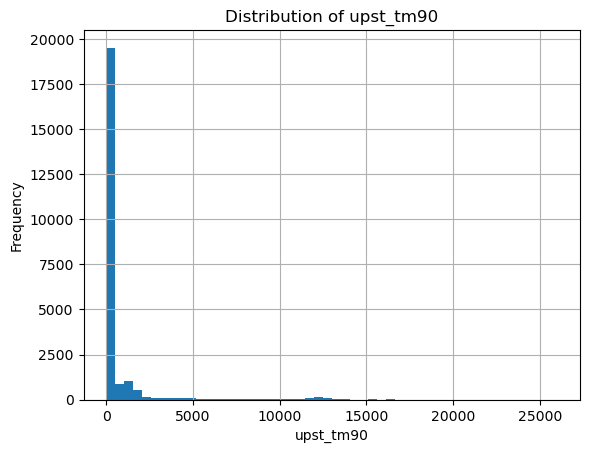

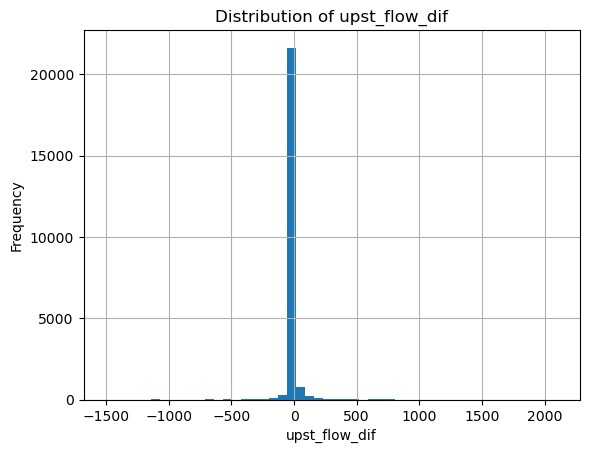

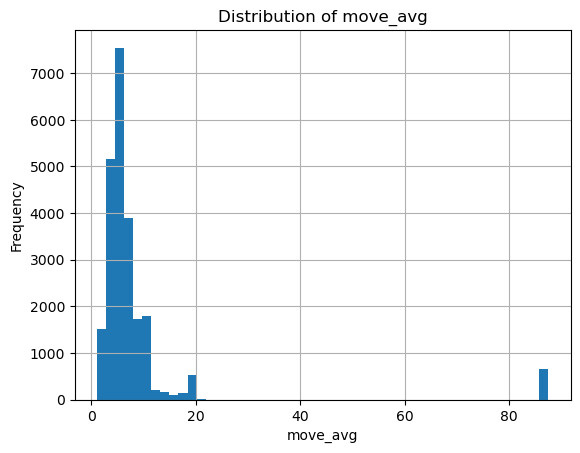

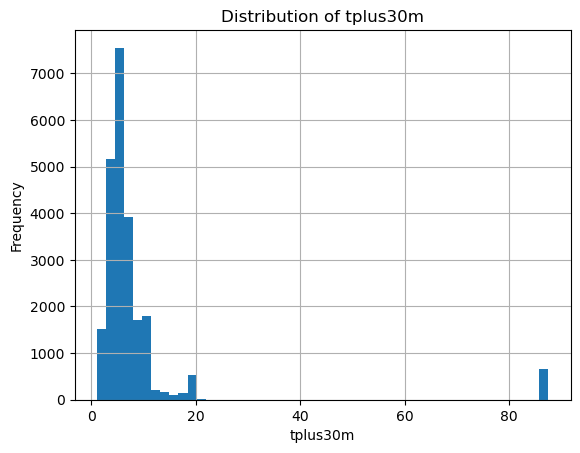

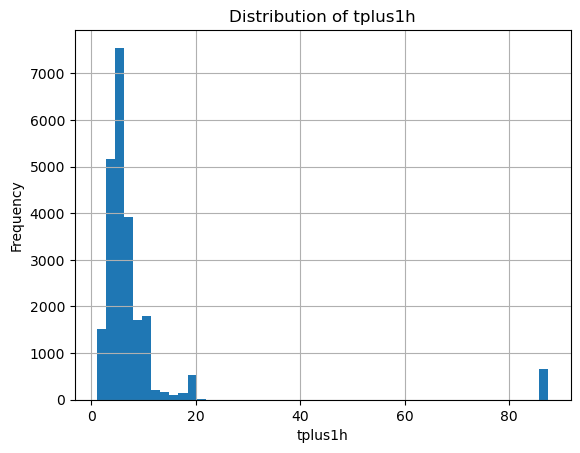

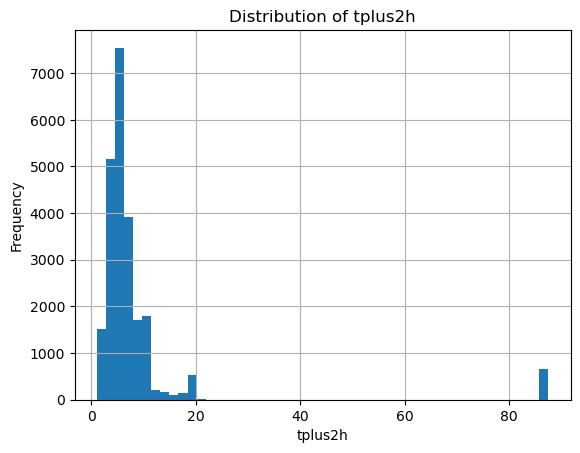

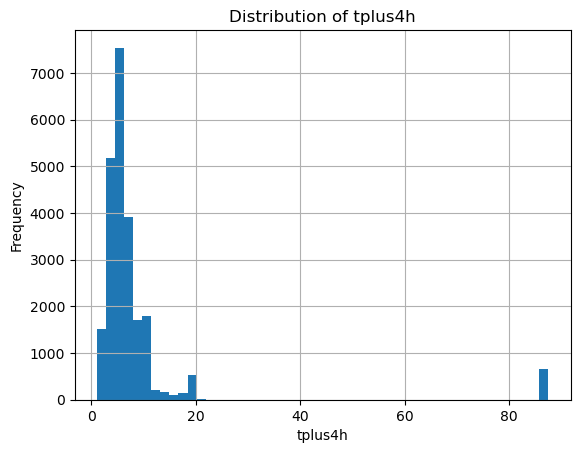

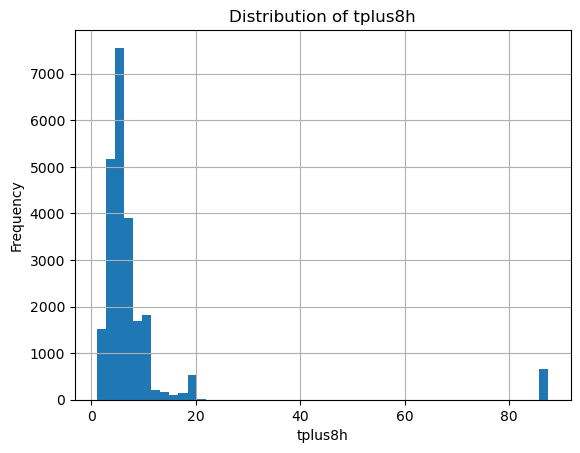

In [11]:
# Feature distributions
features = [
        'site', 'time', 'flow', 'height', 'height_diff', 
        'upstr_flow', 'upst_tm30', 'upst_tm60', 'upst_tm90', 'upst_flow_dif', 
        'move_avg', 'tplus30m', 'tplus1h', 'tplus2h', 'tplus4h', 'tplus8h'
    ]

for feat in features:
    plt.figure()
    df[feat].hist(bins = 50)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()

These feature distribution plots show the same patterns discussed above from the summary statistics.

                   site      time      flow    height  height_diff  \
site           1.000000 -0.039334 -0.224008 -0.052531     0.004370   
time          -0.039334  1.000000  0.034795 -0.008749    -0.069182   
flow          -0.224008  0.034795  1.000000  0.110690     0.010861   
height        -0.052531 -0.008749  0.110690  1.000000     0.000911   
height_diff    0.004370 -0.069182  0.010861  0.000911     1.000000   
upstr_flow    -0.281955  0.018906  0.599280  0.037773     0.084971   
upst_tm30     -0.281839  0.019720  0.601281  0.038055     0.081714   
upst_tm60     -0.281721  0.020534  0.603230  0.038331     0.078620   
upst_tm90     -0.281594  0.021336  0.605124  0.038603     0.075619   
upst_flow_dif -0.002992 -0.026822 -0.067519 -0.009388     0.106857   
move_avg      -0.052546 -0.008513  0.110653  0.999994    -0.002490   
tplus30m      -0.052516 -0.008986  0.110656  0.999994     0.003795   
tplus1h       -0.052500 -0.009221  0.110581  0.999977     0.006370   
tplus2h       -0.052

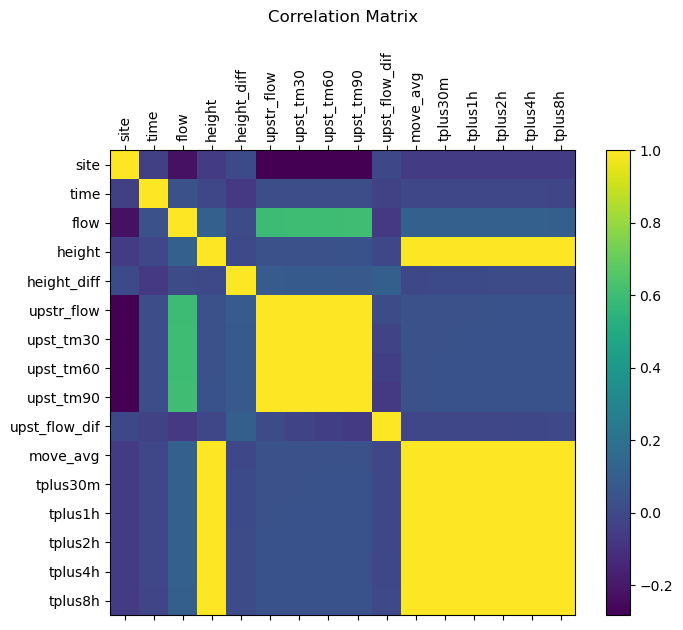

In [13]:
# Correlation matrix
corr = df.corr()

# As table
print(corr)

# As visualization
plt.figure(figsize = (8, 6))
plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix", pad = 20)
plt.colorbar()
plt.show()

**Correlation results:**

`height` vs. `move_avg`:

- `move_avg`, the rolling mean of `height`, is essentially a smoothed version of the same signal. Their correlation with each other is nearly perfect (1.0). As such, we should probably only keep only one of them to prevent multicollinearity. Since future heights are most directly tied to the instantaneous gauge reading, we'll drop `move_avg` and use `height` as our "current‐time" feature.

Upstream flow lags (`upstr_flow`, `upst_tm30`, `upst_tm60`, `upst_tm90`):

- The current upstream flow (`upstr_flow`) and its 30‐min lag (`upst_tm30`) are nearly perfectly correlated (0.9995), as are the longer lags (`upst_tm60`, `upst_tm90`). Including all four will not add information and risks making the model focus splitting on trivial differences.

- We can keep only one representative upstream flow variable plus potentially the upstream flow differential (`upst_flow_dif`) to capture how quickly the upstream flow is changing. We'll drop the three lagged columns (`upst_tm30`, `upst_tm60`, `upst_tm90`) and keep `upstr_flow` and `upst_flow_dif`.

**Conclusions for preprocessing:**

- We should drop certain highly correlated variables.

- We should examine negative values in stream flow variables - see how many there are, and then remove those rows if there aren't many.

- We should convert `time`, which includes both the date and timestamp, into two or three separate date and time variables.

- Since this is time-series data, we should split our data into training and testing sets using a smarter approach than just a random 80/20 split. For each site, we can order the rows by `time` and take the first 80% for training and the last 20% for testing, as attempting to make future predictions is what a real-world model would be used for.

- Since both XGBoost and Random Forest are tree-based, they don't require standard scaling the data.

**Features after preprocessing:**

Predictors:

- `site` (as an integer ID. For RF, it can act as a categorical factor)

- `time_month` (new variable to be created from the month number in `time`. This will always be "4" in our data, as only data from April was pulled)

- `time_day` (new variable to be created from the day number in `time`)

- `time_hour` (new variable to be created from the hour number in `time`)

- `time_minute` (new variable to be created from the minute number in `time`)

- `flow` (current stream flow)

- `height` (current height)

- `height_diff` ($\Delta$ height over the last interval)

- `upstr_flow` (current upstream flow)

- `upst_flow_dif` ($\Delta$ upstream flow over the last interval)

Target (will be one of the following):

- `tplus30m`

- `tplus1h`

- `tplus2h`

- `tplus4h`

- `tplus8h`

We can build a helper function to select the time horizon of interest and return the appropriate data for X_train, X_test, y_train, and y_test accordingly.

## **3.** Data Preprocessing

### Data Fixes

In [18]:
# Remove highly correlated variables
df = df.drop(columns = ['move_avg', 'upst_tm30', 'upst_tm60', 'upst_tm90'])
print(df.head(5))

      site                time   flow  height  height_diff  upstr_flow  \
0  7152000 2025-04-02 22:30:00  121.0    2.40     0.000000        66.3   
1  7152000 2025-04-02 23:00:00  118.0    2.39    -0.006667        66.3   
2  7152000 2025-04-02 23:30:00  118.0    2.39    -0.003333        66.3   
3  7152000 2025-04-03 00:00:00  116.0    2.38    -0.006667        68.3   
4  7152000 2025-04-03 00:30:00  116.0    2.38    -0.003333        66.3   

   upst_flow_dif  tplus30m  tplus1h  tplus2h  tplus4h  tplus8h  
0            0.0      2.39     2.39     2.38     2.38     2.37  
1            0.0      2.39     2.38     2.38     2.38     2.37  
2            0.0      2.38     2.38     2.38     2.38     2.37  
3            2.0      2.38     2.38     2.38     2.37     2.37  
4           -2.0      2.38     2.38     2.38     2.37     2.37  


In [19]:
# Count how many rows have negative 'flow' or 'upstr_flow'
neg_flow_count = (df['flow'] < 0).sum()
neg_upstr_count = (df['upstr_flow'] < 0).sum()
print(f"Rows where flow < 0: {neg_flow_count}")
print(f"Rows where upstr_flow < 0: {neg_upstr_count}")

Rows where flow < 0: 17
Rows where upstr_flow < 0: 0


In [20]:
# Drop rows where 'flow' < 0 and verify
df = df[df['flow'] >= 0].copy()
df.reset_index(drop = True, inplace = True)

neg_flow_count = (df['flow'] < 0).sum()
print(f"Rows where flow < 0: {neg_flow_count}")

Rows where flow < 0: 0


In [21]:
# Extract date and time components from 'time'
df['time_month'] = df['time'].dt.month
df['time_day'] = df['time'].dt.day
df['time_hour'] = df['time'].dt.hour
df['time_minute'] = df['time'].dt.minute

print(df.head(5))
print("\ndf shape:", df.shape)

      site                time   flow  height  height_diff  upstr_flow  \
0  7152000 2025-04-02 22:30:00  121.0    2.40     0.000000        66.3   
1  7152000 2025-04-02 23:00:00  118.0    2.39    -0.006667        66.3   
2  7152000 2025-04-02 23:30:00  118.0    2.39    -0.003333        66.3   
3  7152000 2025-04-03 00:00:00  116.0    2.38    -0.006667        68.3   
4  7152000 2025-04-03 00:30:00  116.0    2.38    -0.003333        66.3   

   upst_flow_dif  tplus30m  tplus1h  tplus2h  tplus4h  tplus8h  time_month  \
0            0.0      2.39     2.39     2.38     2.38     2.37           4   
1            0.0      2.39     2.38     2.38     2.38     2.37           4   
2            0.0      2.38     2.38     2.38     2.38     2.37           4   
3            2.0      2.38     2.38     2.38     2.37     2.37           4   
4           -2.0      2.38     2.38     2.38     2.37     2.37           4   

   time_day  time_hour  time_minute  
0         2         22           30  
1         

### Train/Test Split

In [23]:
# Helper function to split data site-wise and in time order
def train_test_split_by_site(df, train_frac = 0.8):
    """
    Splits df into train/test by site, using the earliest train_frac portion for training.
    Returns two DataFrames: train_df, test_df.
    """
    train_list = []
    test_list = []
    
    for site_id, group in df.groupby('site'):
        group_sorted = group.sort_values('time').reset_index(drop = True)
        n = len(group_sorted)
        train_n = int(train_frac * n)
        
        train_group = group_sorted.iloc[:train_n]
        test_group = group_sorted.iloc[train_n:]
        
        train_list.append(train_group)
        test_list.append(test_group)
    
    train_df = pd.concat(train_list).reset_index(drop = True)
    test_df = pd.concat(test_list).reset_index(drop = True)
    
    return train_df, test_df

In [24]:
train_df, test_df = train_test_split_by_site(df)

print("Train set shape:", train_df.shape)
print("\nTest set shape: ", test_df.shape)

# Example site
print("\nExample site: training set\n")
print(train_df.loc[train_df['site'] == 7152000])
print("\nExample site: testing set\n")
print(test_df.loc[test_df['site'] == 7152000])

Train set shape: (18743, 16)

Test set shape:  (4703, 16)

Example site: training set

        site                time   flow  height  height_diff  upstr_flow  \
0    7152000 2025-04-02 22:30:00  121.0    2.40     0.000000        66.3   
1    7152000 2025-04-02 23:00:00  118.0    2.39    -0.006667        66.3   
2    7152000 2025-04-02 23:30:00  118.0    2.39    -0.003333        66.3   
3    7152000 2025-04-03 00:00:00  116.0    2.38    -0.006667        68.3   
4    7152000 2025-04-03 00:30:00  116.0    2.38    -0.003333        66.3   
..       ...                 ...    ...     ...          ...         ...   
190  7152000 2025-04-10 05:30:00  102.0    2.32     0.000000        69.3   
191  7152000 2025-04-10 13:30:00  109.0    2.35     0.006667        71.3   
192  7152000 2025-04-10 15:30:00  109.0    2.35     0.003333        69.3   
193  7152000 2025-04-10 16:00:00  109.0    2.35     0.003333        69.3   
194  7152000 2025-04-10 16:30:00  109.0    2.35     0.000000        69.3   



In [25]:
# Helper function to get X and y for a given time horizon
def get_Xy_for_horizon(horizon, train_df, test_df):
    """
    Given a horizon column name (like 'tplus1h'), returns:
    X_train, X_test, y_train, y_test DataFrames/Series.
    """

    feature_cols = [
        'site', 'flow', 'height', 'height_diff', 
        'upstr_flow', 'upst_flow_dif', 
        'time_month', 'time_day', 'time_hour', 'time_minute'
    ]
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df[horizon].copy()
    
    X_test = test_df[feature_cols].copy()
    y_test = test_df[horizon].copy()
    
    return X_train, X_test, y_train, y_test

In [26]:
# Example: retrieve X/y for '+1h' horizon
X_train_1h, X_test_1h, y_train_1h, y_test_1h = get_Xy_for_horizon('tplus1h', train_df, test_df)

print("Example shapes for horizon 'tplus1h':")
print("X_train:", X_train_1h.shape, "y_train:", y_train_1h.shape)
print("X_test:", X_test_1h.shape, "y_test:", y_test_1h.shape)

Example shapes for horizon 'tplus1h':
X_train: (18743, 10) y_train: (18743,)
X_test: (4703, 10) y_test: (4703,)


## **4.** Modeling

In [28]:
# Custom Huber loss function, since sklearn.metrics doesn't include it
def huber_loss(y_true, y_pred, delta = 1.0):
    error = y_pred - y_true
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

In [29]:
# List of forecasting horizons
horizons = ['tplus30m', 'tplus1h', 'tplus2h', 'tplus4h', 'tplus8h']
xgb_results = []
rf_results = []

### Model 1: XGBoost (XGB)

In [31]:
for horizon in horizons:
    # Retrieve training/testing data for the given horizon
    X_train, X_test, y_train, y_test = get_Xy_for_horizon(horizon, train_df, test_df)
    
    # XGBoost pipeline
    xgb_pipe = Pipeline([
        ('xgb', XGBRegressor(objective = 'reg:squarederror', random_state = 123))
    ])
    
    # Hyperparameter search space
    xgb_param_dist = {
        'xgb__n_estimators': [100, 200, 500],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.7, 0.8, 1.0],
        'xgb__colsample_bytree': [0.7, 0.8, 1.0]
    }
    
    # Randomized search with 3-fold CV
    xgb_search = RandomizedSearchCV(
        estimator = xgb_pipe,
        param_distributions = xgb_param_dist,
        n_iter = 10,
        cv = 3,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        random_state = 123
    )
    xgb_search.fit(X_train, y_train)
    
    # Best model evaluation on test set
    xgb_best_model = xgb_search.best_estimator_
    xgb_y_pred = xgb_best_model.predict(X_test)
    
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
    xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
    xgb_mape = mean_absolute_percentage_error(y_test, xgb_y_pred) * 100
    xgb_hub = huber_loss(y_test.values, xgb_y_pred)
    xgb_r2 = r2_score(y_test, xgb_y_pred)
    
    xgb_results.append({
        'horizon': horizon,
        'rmse': xgb_rmse,
        'mae': xgb_mae,
        'mape': xgb_mape,
        'huber_loss': xgb_hub,
        'r2': xgb_r2
    })

# Convert results to df for easy viewing
xgb_results_df = pd.DataFrame(xgb_results)
xgb_results_df

,horizon,rmse,mae,mape,huber_loss,r2
0,tplus30m,5.179319,2.167683,32.195186,1.709908,0.855309
1,tplus1h,5.179530,2.169541,32.279225,1.711027,0.855294
2,tplus2h,5.179021,2.169362,32.317764,1.712019,0.855317
3,tplus4h,5.181039,2.178316,32.558464,1.721043,0.855187
4,tplus8h,5.186567,2.199934,33.140761,1.739715,0.854825


In [32]:
# Feature importances
xgb_feature_importances = xgb_best_model.named_steps['xgb'].feature_importances_

xgb_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_feature_importances
}).sort_values(by = 'importance', ascending = False)

xgb_importances_df

,feature,importance
2,height,0.629519
0,site,0.227774
4,upstr_flow,0.098751
1,flow,0.031834
7,time_day,0.008363
5,upst_flow_dif,0.002300
3,height_diff,0.000879
8,time_hour,0.000577
9,time_minute,0.000002
6,time_month,0.000000


**Results of XGBoost model:**

Error/loss:

- Each time horizon has an R$^2$ of around 0.855, which means the model is explaining roughly 85.5% of the variance in future gauge height for each horizon.

- RMSE and MAE barely budge between 30 min and 2 hr. Even out to 4 hr and 8 hr, the errors only increase marginally (RMSE +0.007-0.006 points; MAE +0.011-0.032 points). This near‐flat error curve suggests that the immediate "current height" is overwhelmingly predictive of the near/far future height. In other words, because gauge height changes comparatively slowly (relative to the two‐week window), the best "forecast" for +8 hr is almost the same number as the best forecast for +30 min.

- Each time horizon has an MAE around 2.2, which means that on average, the model is off by about 2 ft regardless of time horizon. That may be acceptable if typical gauge heights in quieter sites are in the 5-15 ft range, but for flood‐risk scenarios (for example, if a gauge is at 80 ft), a 2-ft error could be significant.

- Similarly, MAPE remains around 32-33% for each time horizon. This means that on average, the model's predictions are off by about 32-33% of the actual gauge height.

- Huber loss rises gradually from 1.71 (30 min) to 1.74 (8 hr), similar to RMSE and MAE.

Feature importances:

- The single most important predictor is `height`, the gauge's current height (importance is about 0.6295). This confirms that for near-term forecasting (30 min - 8 hr), simply knowing what the river is doing right now is by far the strongest signal.

- `site` (the gauge's ID number) carries nearly a quarter of the total importance (about 0.2278). In practice, this means XGBoost is learning site-specific baselines or splitting rules. Some sites might tnd to run higher or lower than others, so trees are effectively partitioning on site first, then using `height` (and other features) per site cluster.

- `upstr_flow` (current upstream gauge flow) contributes about 0.0988. This indicates that once the model "knows" which site it's at, and what the current height is, it still uses upstream flow to fine-tune the prediction.

- The local flow reading (`flow`) contributes around 0.0318. That's not negligible, but it's very small compared to height. In other words, given `site` and current gauge height, there's only a slight additional benefit from knowing the instantaneous flow rate.

- `height_diff`, `upst_flow_dif`, and the `time` features contribute nearly nothing, having negligible importances.

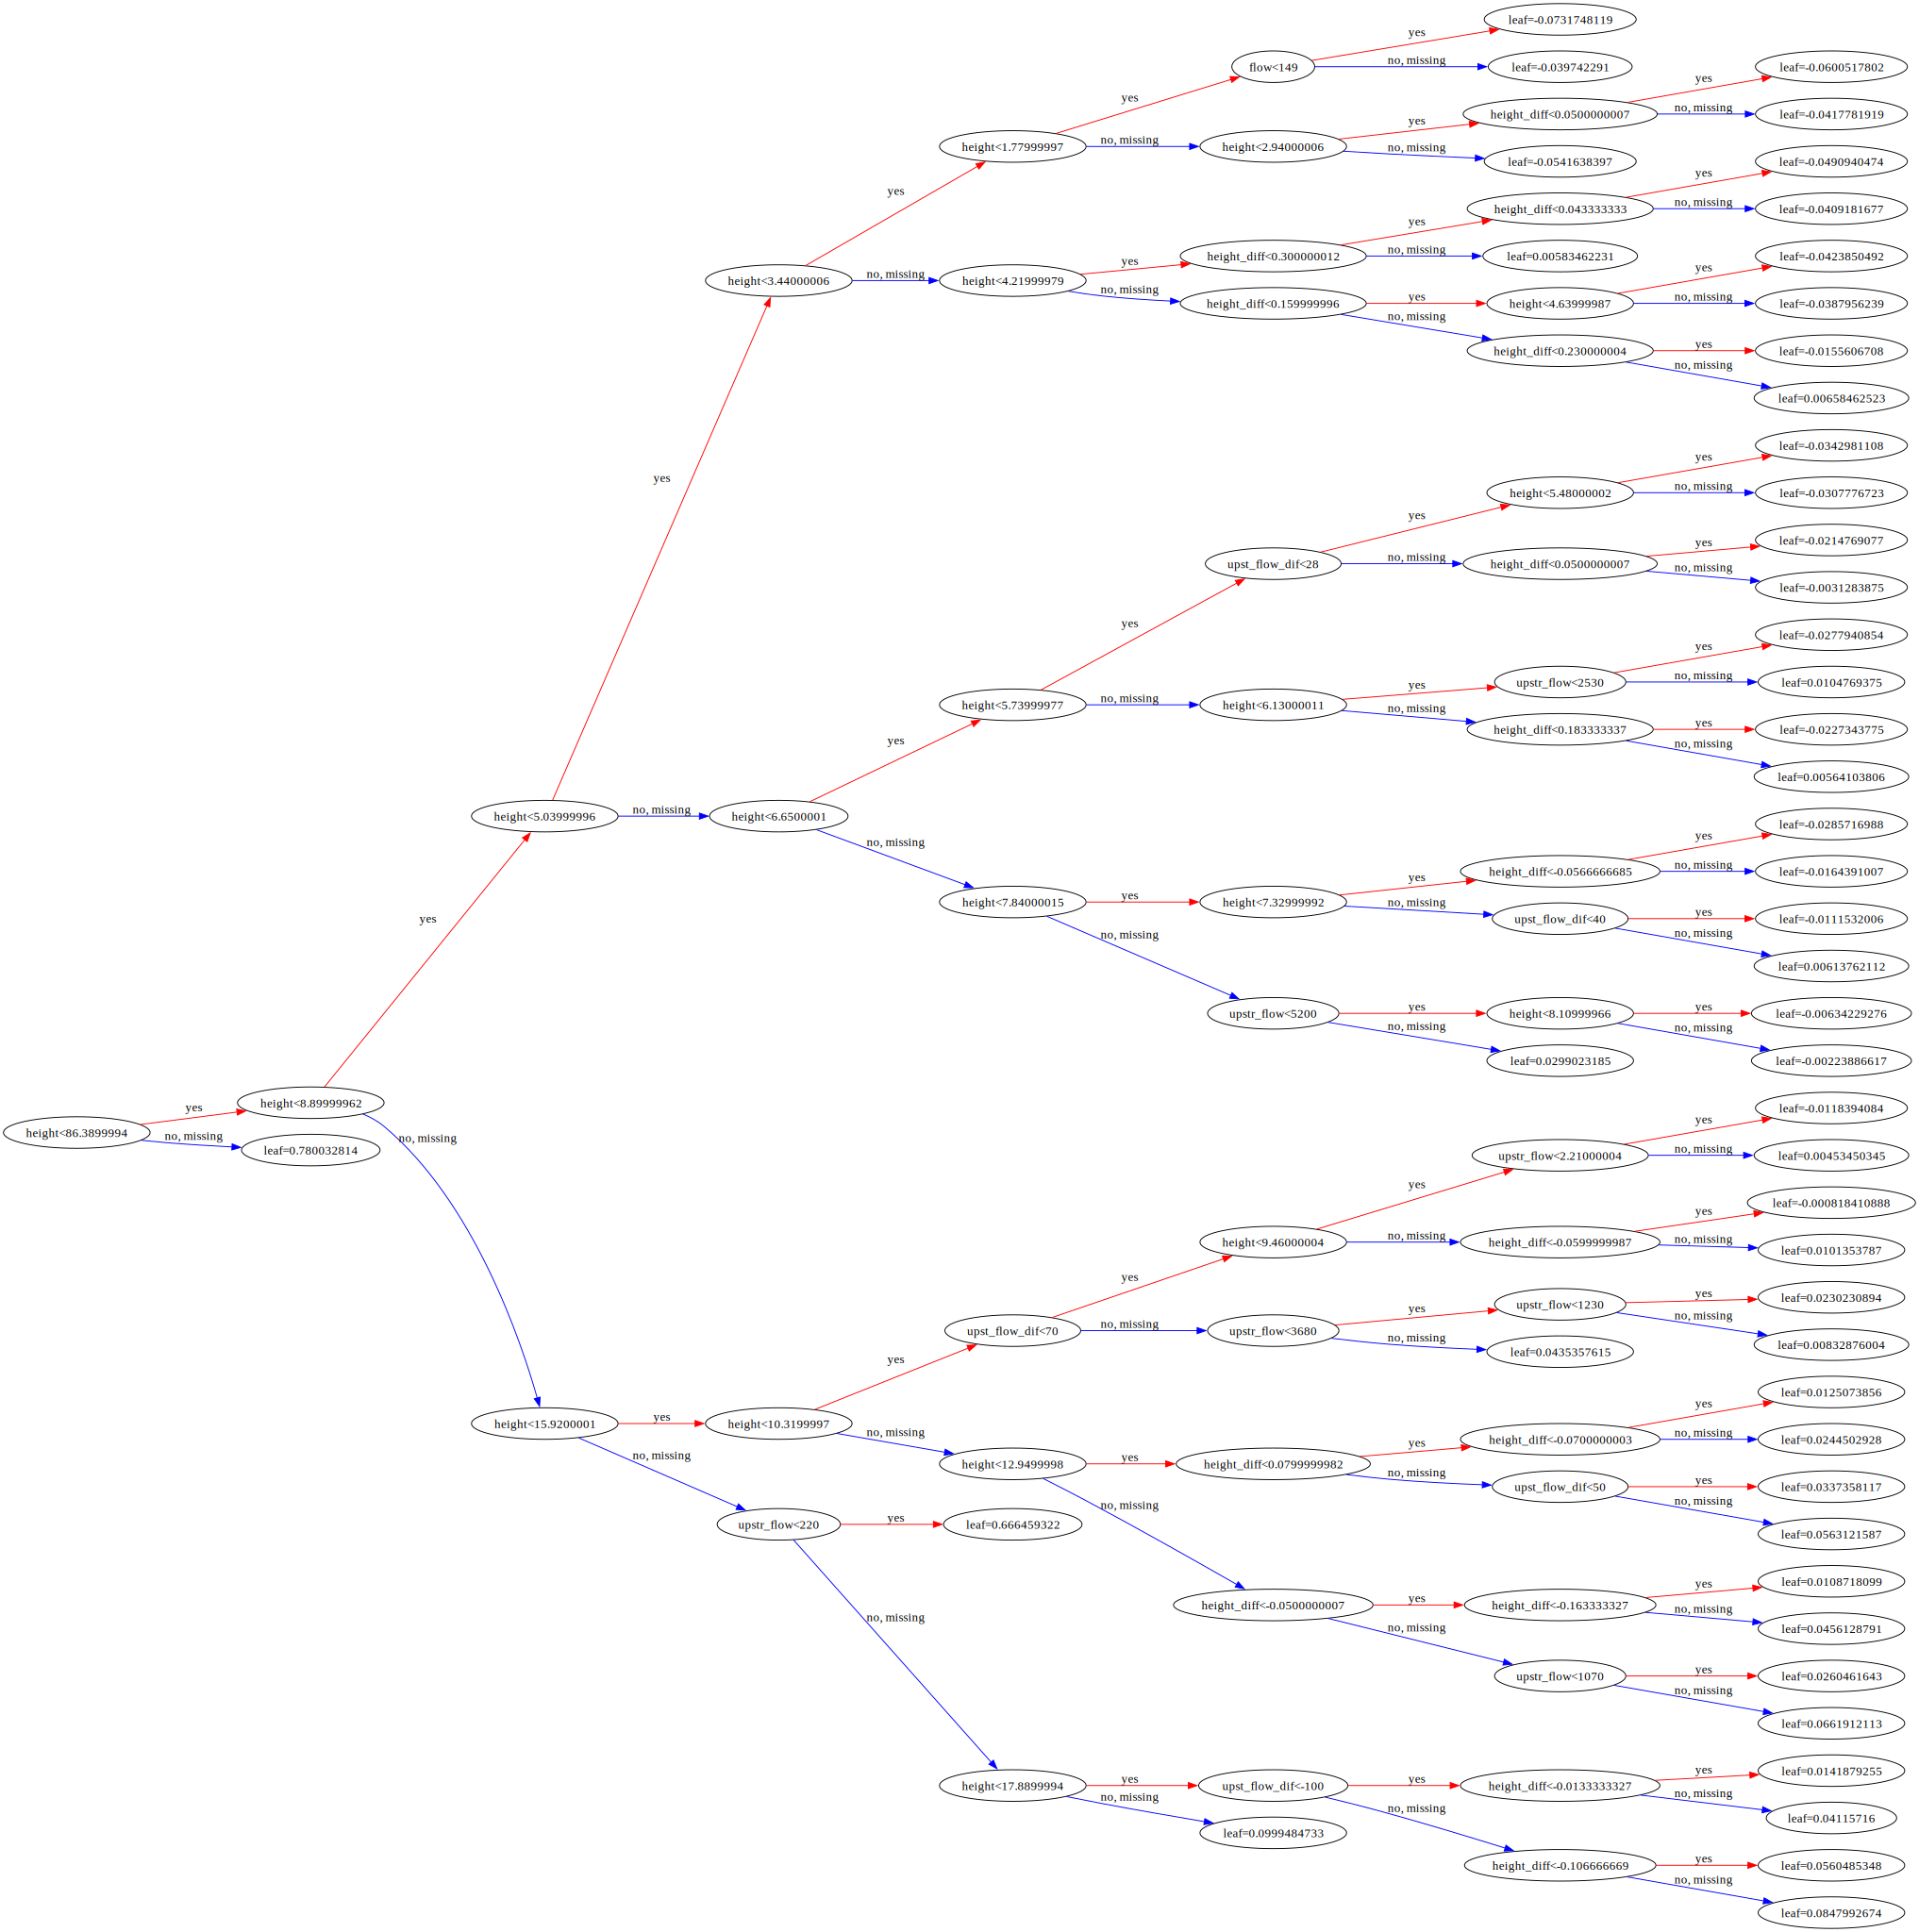

In [34]:
# Visualization for the XGB model
xgb_reg = xgb_best_model.named_steps['xgb']

gv = xgb.to_graphviz(
    xgb_reg,
    tree_idx = 0,
    rankdir = 'LR'
)

# Important note: there doesn't seem to be a way to limit the depth of the tree in the visualization.

# Render as SVG for high resolution
svg_bytes = gv.pipe(format = 'svg')
display(SVG(svg_bytes))

### Model 2: Random Forest (RF)

In [36]:
# Note: this takes a little while to run!

for horizon in horizons:
    # Retrieve training/testing data for the given horizon
    X_train, X_test, y_train, y_test = get_Xy_for_horizon(horizon, train_df, test_df)
    
    # Random Forest pipeline
    rf_pipe = Pipeline([
        ('rf', RandomForestRegressor(random_state = 123))
    ])
    
    # Hyperparameter grid
    rf_param_dist = {
        'rf__n_estimators': [100, 200, 500],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': [None, 'sqrt', 'log2']
    }
    
    # Randomized search with 3-fold CV
    rf_search = RandomizedSearchCV(
        estimator = rf_pipe,
        param_distributions = rf_param_dist,
        n_iter = 10,
        cv = 3,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        random_state = 123
    )
    rf_search.fit(X_train, y_train)
    
    # Evaluate best model on the test set
    rf_best_model = rf_search.best_estimator_
    rf_y_pred = rf_best_model.predict(X_test)
    
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
    rf_mae = mean_absolute_error(y_test, rf_y_pred)
    rf_mape = mean_absolute_percentage_error(y_test, rf_y_pred) * 100
    rf_hub = huber_loss(y_test.values, rf_y_pred)
    rf_r2 = r2_score(y_test, rf_y_pred)
    
    rf_results.append({
        'horizon': horizon,
        'rmse': rf_rmse,
        'mae': rf_mae,
        'mape': rf_mape,
        'huber_loss': rf_hub,
        'r2': rf_r2
    })

# Convert results to a DataFrame for easy viewing
rf_results_df = pd.DataFrame(rf_results)
rf_results_df

,horizon,rmse,mae,mape,huber_loss,r2
0,tplus30m,0.024733,0.016585,0.305161,0.000306,0.999997
1,tplus1h,0.036635,0.023078,0.424513,0.000671,0.999993
2,tplus2h,0.772034,0.310741,5.260068,0.155329,0.996785
3,tplus4h,0.771369,0.319773,5.210488,0.155904,0.996790
4,tplus8h,0.838985,0.340385,5.538675,0.174330,0.996201


In [37]:
# Feature importances
rf_feature_importances = rf_best_model.named_steps['rf'].feature_importances_

rf_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_feature_importances
}).sort_values(by = 'importance', ascending = False)

rf_importances_df

,feature,importance
2,height,0.711964
0,site,0.166083
4,upstr_flow,0.058105
1,flow,0.048755
5,upst_flow_dif,0.008641
7,time_day,0.003786
3,height_diff,0.002381
8,time_hour,0.000263
9,time_minute,0.000022
6,time_month,0.000000


**Results of Random Forest model:**

Error/loss:

- Each time horizon has an R$^2$ of around 0.99, which means the model is explaining almost 100% of the variance in future gauge height for each horizon.

- For the two shortest horizons (30 min and 1 hr), the RF model's RMSE is almost zero (<0.04 ft), reflecting that gauge height changes are minimal over a 30-60 minute window and that `site` combined with `height` alone are enough to get extremely close. By 2 hr, RMSE jumps to about 0.77 ft and remains near 0.77 ft for 4 hr, rising slightly to 0.84 ft at 8 hr.

- For MAE, on average, at 30 min the RF is off by only about 0.02 ft; at 1 hr by about 0.02 ft; and by 2-8 hr by about 0.31-0.34 ft. These are far lower absolute errors than XGBoost (which consistently had MAE of about 2.2 ft).

- MAPE is negligible at very short horizons (under 0.5%), and increases to about 5.3-5.5% for horizons equal to or more than 2 hr.

- The Huber losses are very small at 30 min and 1 hr. At 2 hr and beyond, the Huber rises to about 0.155-0.174, but these results are much better than those for XGBoost.

Feature importances:

- `height` has the largest importance (about 0.712). As with XGBoost, current gauge height dominates because water levels change slowly over short windows, making it the single most predictive variable for +30 min through +8 h.

- `site` (gauge ID) is next (about 0.166). RF, like XGB, learns site‐specific baselines. Some gauges run higher, lower, or fluctuate differently, so splitting on site early helps it fine‐tune predictions per location.

- `upstr_flow` contributes about 0.058. Once RF knows which gauge and its height, upstream flow still adds meaningful nuance, especially if a downstream gauge is about to rise or fall.

- `flow` contributes about 0.049, similar in importance to `upstr_flow`.

- `upst_flow_dif`, `height_diff`, and the `time` features contribute nearly nothing, having negligible importances - this was also the case for XGBoost.

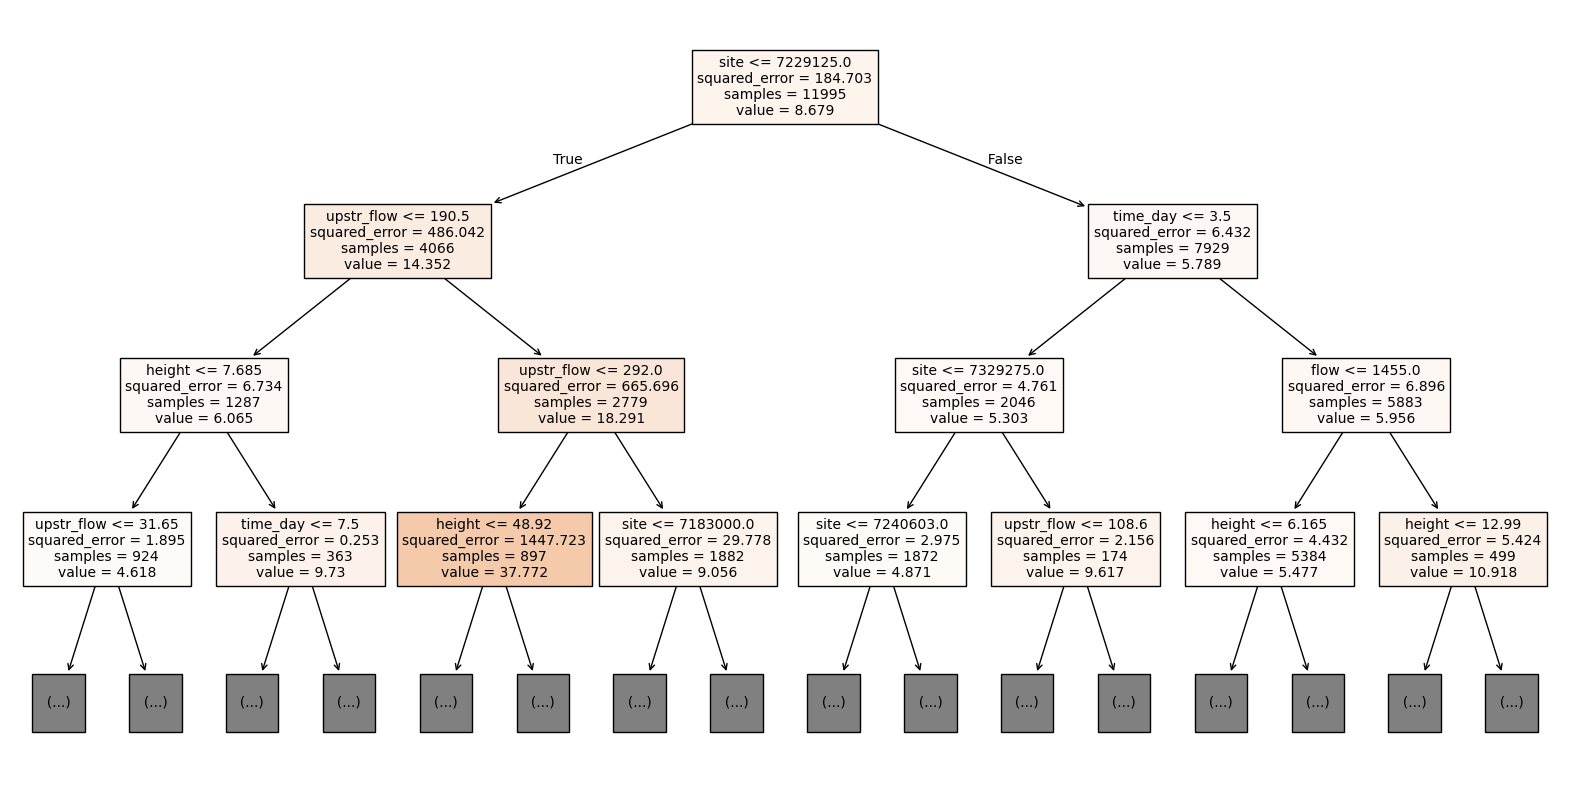

In [39]:
# Visualization for the RF model
# First estimator in the forest for visualization purposes
one_tree = rf_best_model.named_steps['rf'].estimators_[0]

# Plot the tree (limit to depth = 3 for clarity)
plt.figure(figsize = (20, 10))
plot_tree(
    one_tree,
    feature_names = X_train_1h.columns,
    max_depth = 3,
    filled = True,
    fontsize = 10
)
plt.show()

## **5.** Evaluation

### Visualizations

In [42]:
# Combine results into a single df
xgb_results_df['model'] = 'XGBoost'
rf_results_df['model'] = 'RandomForest'
combined_results = pd.concat([xgb_results_df, rf_results_df], ignore_index = True)

<Figure size 800x500 with 0 Axes>

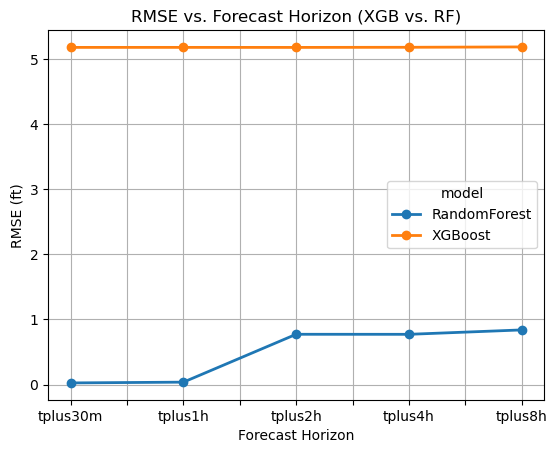

In [43]:
# Plot RMSE vs. Horizon

rmse_df = combined_results.pivot(index = 'horizon', columns = 'model', values = 'rmse')

# Reorder horizons chronologically
ordered_horizons = ['tplus30m', 'tplus1h', 'tplus2h', 'tplus4h', 'tplus8h']
rmse_df = rmse_df.reindex(ordered_horizons)

# Plot RMSE vs. forecast horizon
plt.figure(figsize = (8, 5))
rmse_df.plot(kind = 'line', marker = 'o', linewidth = 2, legend = True)
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE (ft)')
plt.title('RMSE vs. Forecast Horizon (XGB vs. RF)')
plt.grid(True)
plt.show()

In [44]:
# Examination of +1h horizon

# Retrieve data and predictions for +1h
X_train_1h, X_test_1h, y_train_1h, y_test_1h = get_Xy_for_horizon('tplus1h', train_df, test_df)
xgb_preds_1h = xgb_best_model.predict(X_test_1h)
rf_preds_1h = rf_best_model.predict(X_test_1h)

# Compute residuals
xgb_residuals = y_test_1h.values - xgb_preds_1h
rf_residuals = y_test_1h.values - rf_preds_1h

# Compute errors
xgb_errors = xgb_preds_1h - y_test_1h.values
rf_errors = rf_preds_1h - y_test_1h.values

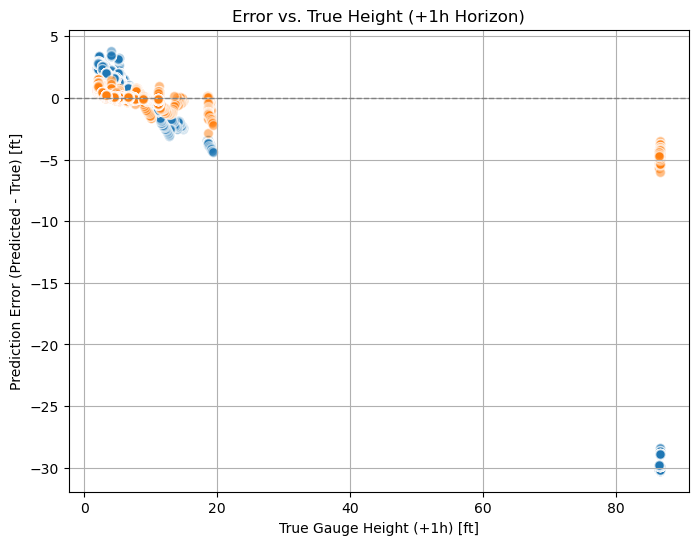

In [45]:
# Plot error vs. true height
plt.figure(figsize = (8, 6))
plt.scatter(y_test_1h, xgb_errors, alpha = 0.5, edgecolors = 'w', s = 50, label = 'XGB Errors')
plt.scatter(y_test_1h, rf_errors, alpha = 0.5, edgecolors = 'w', s = 50, label = 'RF Errors')
plt.axhline(0, color = 'gray', linewidth = 1, linestyle = '--')
plt.xlabel('True Gauge Height (+1h) [ft]')
plt.ylabel('Prediction Error (Predicted - True) [ft]')
plt.title('Error vs. True Height (+1h Horizon)')
plt.grid(True)
plt.show()

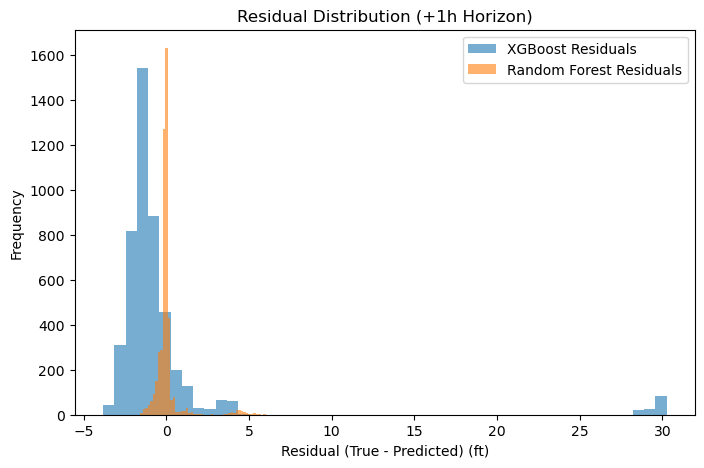

In [46]:
# Plot histograms of residuals
plt.figure(figsize = (8, 5))
plt.hist(xgb_residuals, bins = 50, alpha = 0.6, label = 'XGBoost Residuals')
plt.hist(rf_residuals, bins = 50, alpha = 0.6, label = 'Random Forest Residuals')
plt.xlabel('Residual (True - Predicted) (ft)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (+1h Horizon)')
plt.legend()
plt.show()

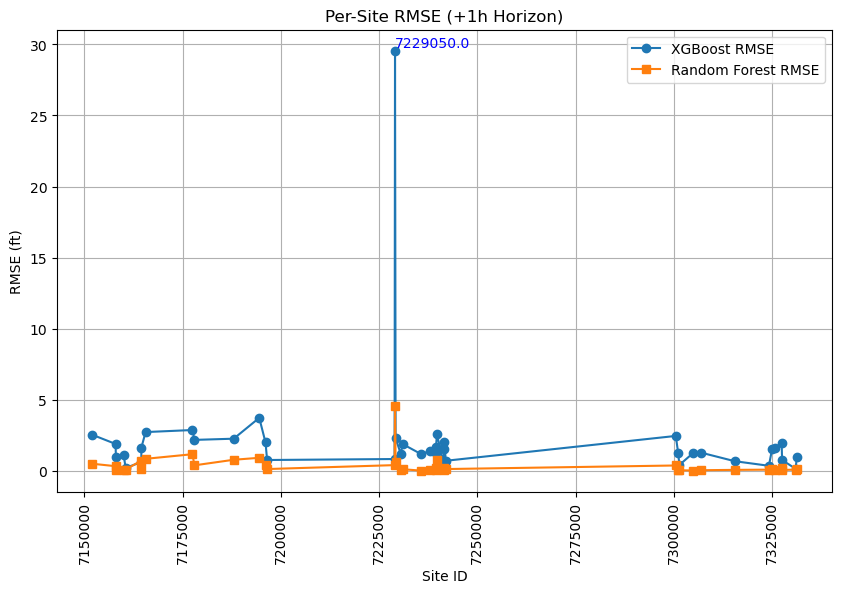

In [47]:
# Site‐level RMSE for +1h horizon

# Add site and residuals to a df
site_df = X_test_1h[['site']].copy()
site_df['xgb_resid'] = xgb_residuals
site_df['rf_resid'] = rf_residuals

# Compute per-site RMSE for each model
site_rmse = site_df.groupby('site').agg({
    'xgb_resid': lambda x: np.sqrt(np.mean(x ** 2)),
    'rf_resid': lambda x: np.sqrt(np.mean(x ** 2))
}).reset_index().rename(columns = {
    'xgb_resid': 'xgb_rmse',
    'rf_resid': 'rf_rmse'
})

# Plot per-site RMSE
plt.figure(figsize = (10, 6))
plt.plot(site_rmse['site'], site_rmse['xgb_rmse'], marker = 'o', linestyle = '-', label = 'XGBoost RMSE')
plt.plot(site_rmse['site'], site_rmse['rf_rmse'], marker = 's', linestyle = '-', label = 'Random Forest RMSE')
plt.xlabel('Site ID')
plt.ylabel('RMSE (ft)')
plt.title('Per-Site RMSE (+1h Horizon)')
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)
plt.ticklabel_format(style = 'plain')

# label data points with their site ID if their RMSE is particularly large
for idx, row in site_rmse.iterrows():
    site_id = row['site']
    xgb_val = row['xgb_rmse']
    rf_val = row['rf_rmse']
    if xgb_val > 10:
        plt.text(site_id, xgb_val, str(site_id), color = 'blue', fontsize = 10, va = 'bottom')
    if rf_val > 10:
        plt.text(site_id, rf_val, str(site_id), color = 'orange', fontsize = 10, va = 'bottom')

plt.show()

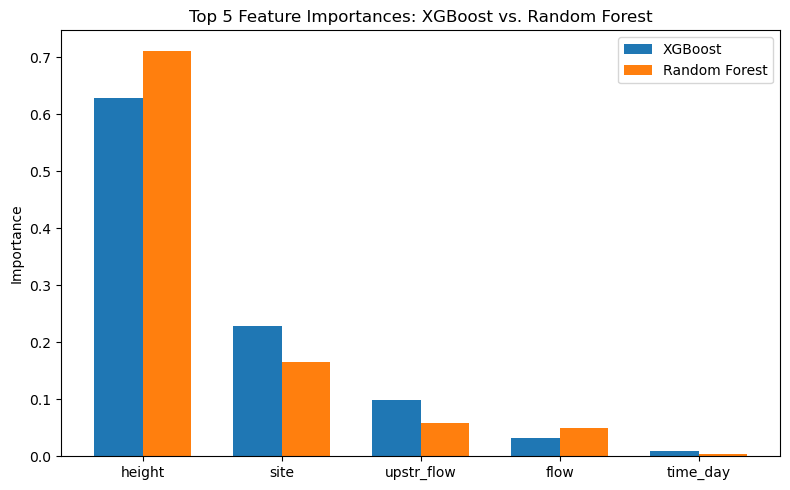

In [48]:
# Feature importance comparison (top 5)

# Create df for importances
feature_names = X_train_1h.columns.tolist()
xgb_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_feature_importances
})
rf_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_feature_importances
})

# Merge and select top 5 by average importance
imp_df = xgb_imp_df.merge(rf_imp_df, on = 'feature', suffixes = ('_xgb', '_rf'))
imp_df['avg_importance'] = (imp_df['importance_xgb'] + imp_df['importance_rf']) / 2
top5 = imp_df.sort_values('avg_importance', ascending = False).head(5)

# Plot side-by-side bar chart
x = np.arange(len(top5))
width = 0.35
plt.figure(figsize = (8, 5))
plt.bar(x - width/2, top5['importance_xgb'], width, label = 'XGBoost')
plt.bar(x + width/2, top5['importance_rf'], width, label = 'Random Forest')
plt.xticks(x, top5['feature'])
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances: XGBoost vs. Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

### Discussion

**Comparison of models:**

We compared two tree-based regression models, XGBoost (XGB) and Random Forest (RF), for forecasting future water height at stream gauges. Both models were evaluated across five future time horizons: +30 minutes, +1 hour, +2 hours, +4 hours, and +8 hours.

RF consistently outperformed XGB across all metrics. For short-term forecasts (+30m, +1h), RF achieved exceptionally low RMSE (0.02-0.04 ft), MAE (about 0.02 ft), and near-zero Huber loss, with R$^2$ scores above 0.999. Even at longer horizons (like +8h), RF maintained strong predictive power (RMSE of about 0.84 ft, R$^2$ of about 0.996), suggesting strong generalization.

In contrast, XGBoost's performance remained relatively stable but was substantially less accurate across all horizons (RMSE of about 5.18 ft, R$^2$ of about 0.855). The error magnitudes suggest that XGB underfit the data compared to RF.

Both models identified current gauge height as the most important predictor. Secondary features like site ID and upstream flow were also relevant. Temporal features (time of day, time of month) and flow differentials had minimal importance for both models.

Overall, RF had much better performance than XGB.

**Limitations:**

There are some limitations present within the data. The model was trained exclusively on data from Oklahoma stream gauges, so performance may differ in other regions/states with different weather patterns or river systems.

The data span was only 14 days. Longer-term patterns such as seasonal stream flow variation were not captured, and storm events or droughts may not captured (or at least only partially). This may limit the model's robustness over extended periods or during other seasons aside from Spring.

Including site ID as a predictor improves model accuracy, but makes the model less generalizable to unseen locations/sites.

### Final model

In [51]:
# Remove insignificant features
df = df.drop(columns = ['upst_flow_dif', 'height_diff', 'time_month', 'time_day', 'time_hour', 'time_minute'])

# Remove site 7229050
df = df[df['site'] != 7229050].copy()
df.reset_index(drop = True, inplace = True)

# Redo train/test split
train_df, test_df = train_test_split_by_site(df)

print("Train set shape:", train_df.shape)
print("\nTest set shape: ", test_df.shape)

Train set shape: (18220, 10)

Test set shape:  (4572, 10)


In [52]:
# Redo RF model
new_rf_results = []

# New helper function to get X and y for a given time horizon
def new_get_Xy_for_horizon(horizon, train_df, test_df):
    """
    Given a horizon column name (like 'tplus1h'), returns:
    X_train, X_test, y_train, y_test DataFrames/Series.
    """

    feature_cols = ['site', 'flow', 'height', 'upstr_flow']
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df[horizon].copy()
    
    X_test = test_df[feature_cols].copy()
    y_test = test_df[horizon].copy()
    
    return X_train, X_test, y_train, y_test
    
# Other helper function and list of horizons stays the same

for horizon in horizons:
    # Retrieve training/testing data for the given horizon
    X_train, X_test, y_train, y_test = new_get_Xy_for_horizon(horizon, train_df, test_df)
    
    # Random Forest pipeline
    new_rf_pipe = Pipeline([
        ('rf', RandomForestRegressor(random_state = 123))
    ])
    
    # Hyperparameter grid
    new_rf_param_dist = {
        'rf__n_estimators': [100, 200, 500],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': [None, 'sqrt', 'log2']
    }
    
    # Randomized search with 3-fold CV
    new_rf_search = RandomizedSearchCV(
        estimator = new_rf_pipe,
        param_distributions = new_rf_param_dist,
        n_iter = 10,
        cv = 3,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        random_state = 123
    )
    new_rf_search.fit(X_train, y_train)
    
    # Evaluate best model on the test set
    new_rf_best_model = new_rf_search.best_estimator_
    new_rf_y_pred = new_rf_best_model.predict(X_test)
    
    new_rf_rmse = np.sqrt(mean_squared_error(y_test, new_rf_y_pred))
    new_rf_mae = mean_absolute_error(y_test, new_rf_y_pred)
    new_rf_mape = mean_absolute_percentage_error(y_test, new_rf_y_pred) * 100
    new_rf_hub = huber_loss(y_test.values, new_rf_y_pred)
    new_rf_r2 = r2_score(y_test, new_rf_y_pred)
    
    new_rf_results.append({
        'horizon': horizon,
        'rmse': new_rf_rmse,
        'mae': new_rf_mae,
        'mape': new_rf_mape,
        'huber_loss': new_rf_hub,
        'r2': new_rf_r2
    })

# Convert results to a DataFrame for easy viewing
new_rf_results_df = pd.DataFrame(new_rf_results)

In [53]:
print("Previous RF results:")
rf_results_df

Previous RF results:


,horizon,rmse,mae,mape,huber_loss,r2,model
0,tplus30m,0.024733,0.016585,0.305161,0.000306,0.999997,RandomForest
1,tplus1h,0.036635,0.023078,0.424513,0.000671,0.999993,RandomForest
2,tplus2h,0.772034,0.310741,5.260068,0.155329,0.996785,RandomForest
3,tplus4h,0.771369,0.319773,5.210488,0.155904,0.996790,RandomForest
4,tplus8h,0.838985,0.340385,5.538675,0.174330,0.996201,RandomForest


In [54]:
print("\nOptimized RF results:")
new_rf_results_df


Optimized RF results:


,horizon,rmse,mae,mape,huber_loss,r2
0,tplus30m,0.036264,0.021407,0.404772,0.000658,0.999870
1,tplus1h,0.066219,0.034983,0.660659,0.002192,0.999566
2,tplus2h,0.136199,0.069544,1.284325,0.009228,0.998161
3,tplus4h,0.266927,0.130673,2.487356,0.034311,0.992910
4,tplus8h,0.367998,0.181740,3.318375,0.062423,0.986451


In [55]:
# Feature importances
new_rf_feature_importances = new_rf_best_model.named_steps['rf'].feature_importances_

new_rf_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': new_rf_feature_importances
}).sort_values(by = 'importance', ascending = False)

In [56]:
print("Previous RF importances:")
rf_importances_df

Previous RF importances:


,feature,importance
2,height,0.711964
0,site,0.166083
4,upstr_flow,0.058105
1,flow,0.048755
5,upst_flow_dif,0.008641
7,time_day,0.003786
3,height_diff,0.002381
8,time_hour,0.000263
9,time_minute,0.000022
6,time_month,0.000000


In [57]:
print("\nOptimized RF importances:")
new_rf_importances_df


Optimized RF importances:


,feature,importance
2,height,0.977439
3,upstr_flow,0.014040
1,flow,0.005201
0,site,0.003320


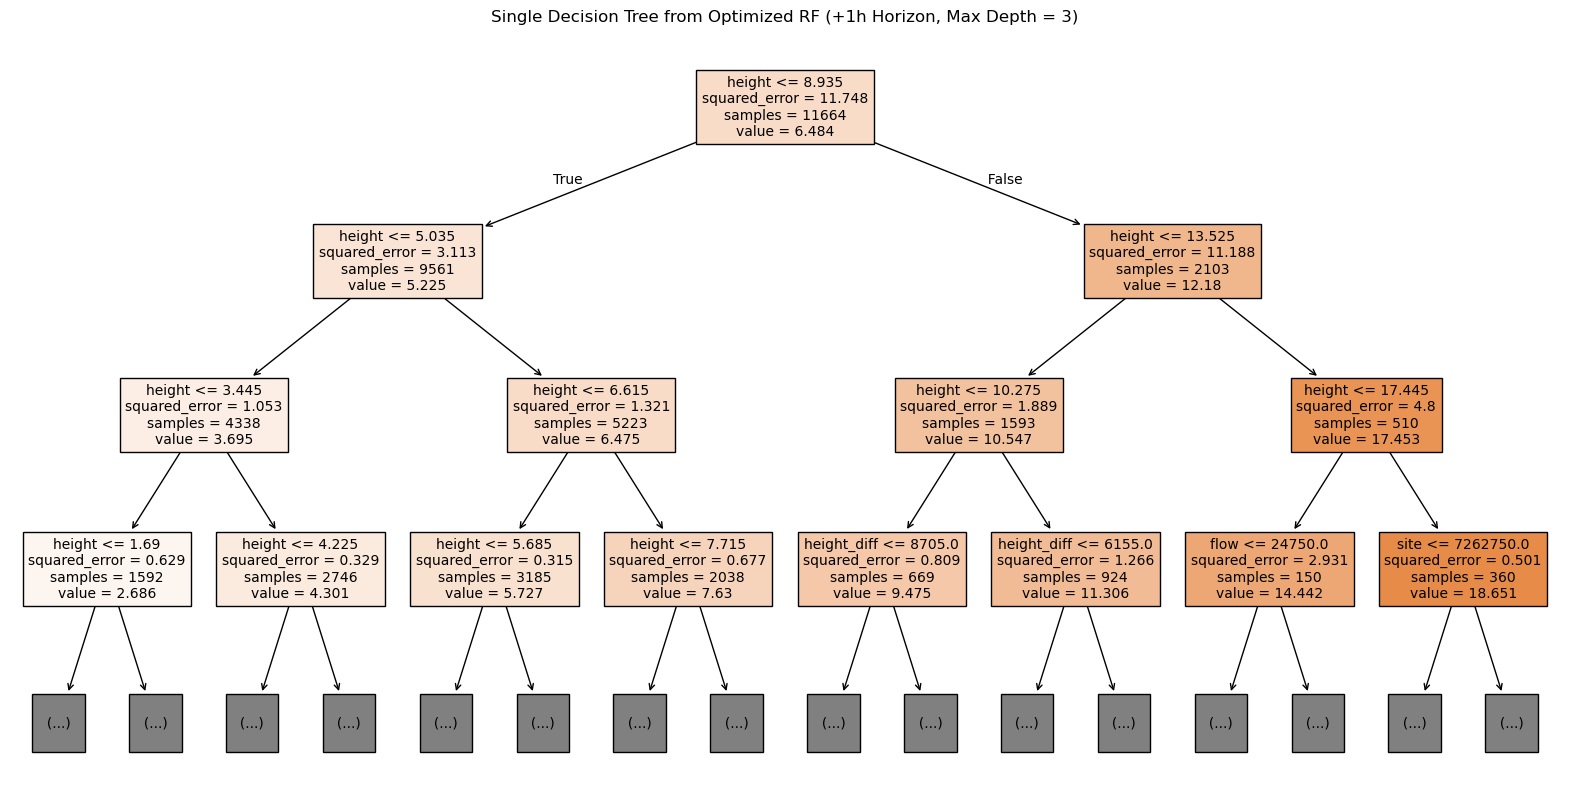

In [58]:
# First estimator in the forest for visualization purposes
one_tree = new_rf_best_model.named_steps['rf'].estimators_[0]

# Plot the tree (limit to depth = 3 for clarity)
plt.figure(figsize = (20, 10))
plot_tree(
    one_tree,
    feature_names = X_train_1h.columns,
    max_depth = 3,
    filled = True,
    fontsize = 10
)
plt.title("Single Decision Tree from Optimized RF (+1h Horizon, Max Depth = 3)")
plt.show()

In [59]:
# Combine both RF results into a single df
rf_results_df['model'] = 'Previous RF'
new_rf_results_df['model'] = 'Optimized RF'
combined_results = pd.concat([rf_results_df, new_rf_results_df], ignore_index = True)

<Figure size 800x500 with 0 Axes>

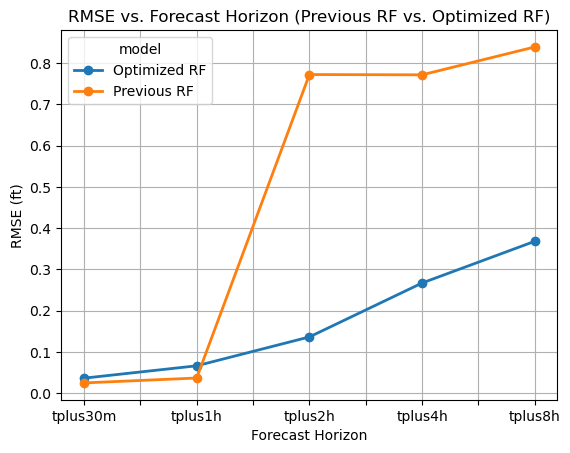

In [60]:
# Plot RMSE vs. Horizon

rmse_df = combined_results.pivot(index = 'horizon', columns = 'model', values = 'rmse')

# Reorder horizons chronologically
ordered_horizons = ['tplus30m', 'tplus1h', 'tplus2h', 'tplus4h', 'tplus8h']
rmse_df = rmse_df.reindex(ordered_horizons)

# Plot RMSE vs. forecast horizon
plt.figure(figsize = (8, 5))
rmse_df.plot(kind = 'line', marker = 'o', linewidth = 2, legend = True)
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE (ft)')
plt.title('RMSE vs. Forecast Horizon (Previous RF vs. Optimized RF)')
plt.grid(True)
plt.show()

In [61]:
# Residual analysis for +1h horizon

# Retrieve data and predictions for +1h
X_train_1h, X_test_1h, y_train_1h, y_test_1h = new_get_Xy_for_horizon('tplus1h', train_df, test_df)
new_rf_preds_1h = new_rf_best_model.predict(X_test_1h)

# Compute residuals
new_rf_residuals = y_test_1h.values - new_rf_preds_1h

# Compute errors
new_rf_errors = new_rf_preds_1h - y_test_1h.values

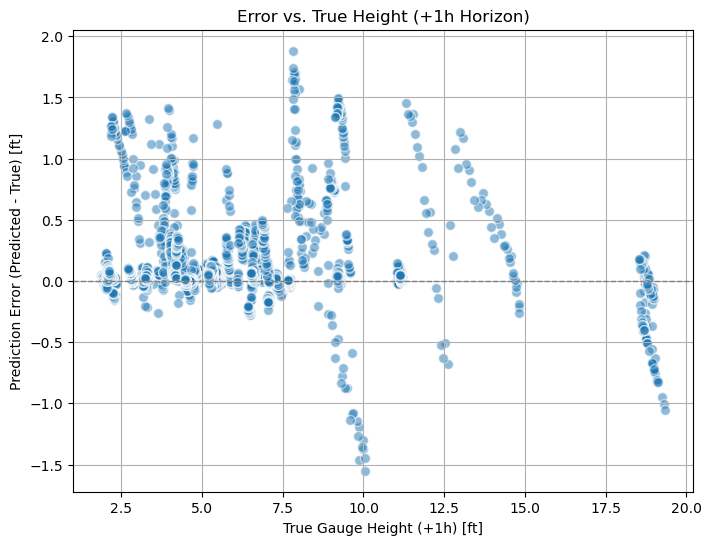

In [62]:
# Plot error vs. true height
plt.figure(figsize = (8, 6))
plt.scatter(y_test_1h, new_rf_errors, alpha = 0.5, edgecolors = 'w', s = 50, label = 'Optimized RF Errors')
plt.axhline(0, color = 'gray', linewidth = 1, linestyle = '--')
plt.xlabel('True Gauge Height (+1h) [ft]')
plt.ylabel('Prediction Error (Predicted - True) [ft]')
plt.title('Error vs. True Height (+1h Horizon)')
plt.grid(True)
plt.show()

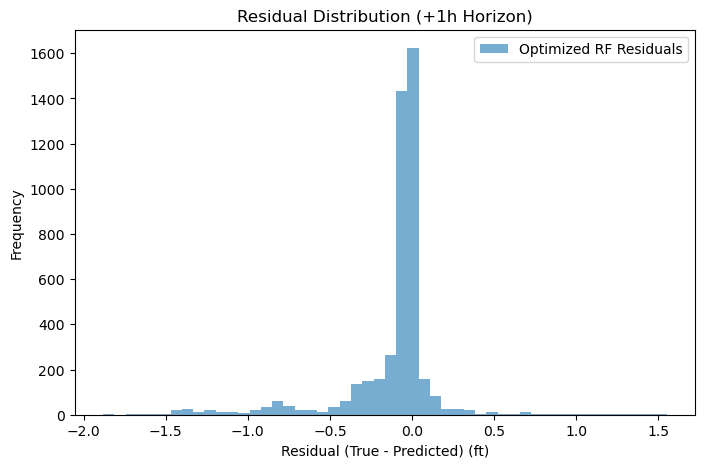

In [63]:
# Plot histograms of residuals - just new RF
plt.figure(figsize = (8, 5))
plt.hist(new_rf_residuals, bins = 50, alpha = 0.6, label = 'Optimized RF Residuals')
plt.xlabel('Residual (True - Predicted) (ft)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (+1h Horizon)')
plt.legend()
plt.show()

In [64]:
# Nash-Sutcliffe Efficiency
def nse(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    if denominator == 0:
        return np.nan if numerator != 0 else 1.0
    return 1 - (numerator / denominator)

print("Nash-Sutcliffe Efficiency score:")
print(nse(y_test_1h.values, new_rf_preds_1h))

Nash-Sutcliffe Efficiency score:
0.9899039980268282
